In [1]:
# imports
import pandas as pd

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import os
import sys
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# cnn imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, LSTM, Bidirectional, Layer, Input
from tensorflow.python.keras.layers import Input, Dense, Embedding, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from tensorflow.keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier

#from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from numpy import array

from datetime import datetime

import timeit

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True))

local_bert_path =   '<your local BERT path>' # change as needed
#data_path = '<your data path>'  # path to ner_dataset.csv file , from 
data_path = 'data\\'  # path to ner_dataset.csv file , from 

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

## 1. Baseline (Body text shorten: keep first n tokens)

### Baseline 1. Load Data

In [147]:
# Load data
bodies_df = pd.read_csv("train_bodies.csv")
stances_df =  pd.read_csv("train_stances.csv")
#bodies_df = pd.read_csv("trainbodywithsummary.csv")
#bodies_df = pd.read_csv("new_trainbodywithsummary.csv")


'bodies_df.shape\nbodies_df.head()\nstances_df.shape\nstances_df.head()\nstances_df.head()'

### Baseline 2. Prepare Data

In [149]:
#combine body and stance tables
combined = pd.concat([stances_df.set_index('Body ID'),bodies_df.set_index('Body ID')], axis=1, join='inner').reset_index()
combined_df_t=combined[['Headline', 'articleBody', 'Stance']]
combined_df_t.head()

# Extract column for just labels
labels_t = combined_df_t['Stance']

# Examine data shape
'''bodies_df.shape
bodies_df.head
stances_df.shape
combined_df_t.head()'''

combined_df_t = combined_df_t.rename(columns={'summary_random': 'articleBody'})
# Or rename the existing DataFrame (rather than creating a copy) 
combined_df_t.rename(columns={'summary_random': 'articleBody'}, inplace=True)
#combined_df_t.head()

# Drop columns that are strings
all_data_processed = combined_df_t.drop(['Stance'], axis=1)

new_labels1= labels_t.copy()
new_labels1[new_labels1=='agree']=3
new_labels1[new_labels1=='unrelated']=2
new_labels1[new_labels1=='disagree']=0
new_labels1[new_labels1=='discuss']=1
new_labels1h = np_utils.to_categorical(new_labels1)

all_data_processed.head()

# Set some variables to hold test, dev, and training data.
test_data, test_labels_1h = all_data_processed[:1000], new_labels1h[:1000]
dev_data, dev_labels_1h = all_data_processed[1001:7000], new_labels1h[1001:7000]
train_data, train_labels_1h = all_data_processed[7001:], new_labels1h[7001:]


### Baseline 3. GloVe Embedding

In [150]:
# Used GLoVE embeddings
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

### Baseline 4. Define Needed Functions

In [151]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def sent_to_ids(sentences):
    """
    converting a list of strings to a list of lists of word ids
    """
    
    #re.sub('[^A-Za-z0-9]+', '', mystring)
    #cleanString = re.sub('\W+','', string ) 
    
    bad_chars = [';', ':', '!', "*"] 
    
    text_ids = []
    example = []
    sentences = sentences.replace('.','')
    sentences = sentences.replace('\'','')
    sentences = sentences.replace(',','')
    sentences = sentences.replace('$','')
    sentences = sentences.replace('/',' ')
    sentences = sentences.replace('','')
    for word in sentences.split(' '):
        #word.lower()
        temp = word.lower()
        #temp.replace('\'','')
        if temp in embeddings_dict:
            example.append(embeddings_dict[temp])
        else:
            print("Missing ", temp)            
    text_ids.append(example)

    return  text_ids   

# This is a hepler method to display and plot results
def showResults(history):
    val_acc = np.array(history.history['val_main_output_f1_metric'])
    train_ac = np.array(history.history['main_output_f1_metric'])
    print("Best validation F1 Score: %.4f" % max(val_acc))
    print("Best train F1 Score: %.4f" %  max(train_ac))

    plt.figure(figsize=(14, 4))
    ax = plt.subplot(121)

    # Plot Loss Vs Epoch for Train and validation Sets
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot( [i + 1 for i in range(len(history.history['loss']))], history.history['loss'],  '-gD', marker='o', label="Training loss")
    plt.plot( [i + 1 for i in range(len(history.history['val_loss']))], history.history['val_loss'],  '-bD', marker='o', label="Validation loss")
    plt.legend(loc="best")

    # Plot Accuracy Vs Epoch for Train and validation Sets
    ax = plt.subplot(122)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot( [i + 1 for i in range(len(history.history['main_output_f1_metric']))], history.history['main_output_f1_metric'],  '-gD', marker='o', label="Train F1 Score")
    plt.plot( [i + 1 for i in range(len(history.history['val_main_output_f1_metric']))], history.history['val_main_output_f1_metric'],  '-bD', marker='o', label="Validation F1 Score")
    plt.legend(loc="best")

def encodeDoc(data, size):
# integer encode the documents
    encoded_docs = t.texts_to_sequences(data)
    # pad documents to a max length of 4 words
    max_length = size
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
 
    return padded_docs

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Baseline 5. Set Parameters for GridSearch (Body text shorten: keep first n tokens)

In [155]:
#Parameters
# Define maximal length of input 'sentences' (post tokenization).
headlineshape_parameter_list = [15]
bodyshape_parameter_list = [100,185]

#create optimizer options
sgd1 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd2 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
Adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.01)
Adadelta = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
adam1 = 'adam'
optimizer_parameter_list = [Adadelta]

#epochs, batch parameter
epochs_parameter_list = [10,20]
batch_size = 30

### Start of For loop to find best F1 score baseline model (Body text shorten: keep first n tokens)

Headline Shape: 15
Body Shape: 100
Max length: 115
Optimizer: <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000023B5F73A308>
Epochs: 10
Loaded 400000 word vectors.
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
headline_input (InputLayer)     [(None, 15)]         0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 15, 50)       2487000     headline_input[0][0]             
__________________________________________________________________________________________________
embe

4799/4799 [==============================] - 43s 9ms/sample - loss: 1.9685 - main_output_loss: 0.5751 - headline_out_loss: 0.7250 - body_out_loss: 0.6684 - main_output_acc: 0.7916 - main_output_f1_metric: 0.7857 - headline_out_acc: 0.7320 - headline_out_f1_metric: 0.7310 - body_out_acc: 0.7470 - body_out_f1_metric: 0.7459 - val_loss: 2.1541 - val_main_output_loss: 0.6869 - val_headline_out_loss: 0.7578 - val_body_out_loss: 0.7094 - val_main_output_acc: 0.7692 - val_main_output_f1_metric: 0.7568 - val_headline_out_acc: 0.7417 - val_headline_out_f1_metric: 0.7393 - val_body_out_acc: 0.7533 - val_body_out_f1_metric: 0.7498
Epoch 8/10
4799/4799 [==============================] - 41s 9ms/sample - loss: 1.9088 - main_output_loss: 0.5451 - headline_out_loss: 0.7180 - body_out_loss: 0.6458 - main_output_acc: 0.8037 - main_output_f1_metric: 0.8019 - headline_out_acc: 0.7316 - headline_out_f1_metric: 0.7304 - body_out_acc: 0.7531 - body_out_f1_metric: 0.7511 - val_loss: 2.2206 - val_main_output_

4799/4799 [==============================] - 42s 9ms/sample - loss: 2.3018 - main_output_loss: 0.7640 - headline_out_loss: 0.7703 - body_out_loss: 0.7676 - main_output_acc: 0.7362 - main_output_f1_metric: 0.7333 - headline_out_acc: 0.7322 - headline_out_f1_metric: 0.7313 - body_out_acc: 0.7316 - body_out_f1_metric: 0.7290 - val_loss: 2.7039 - val_main_output_loss: 1.1885 - val_headline_out_loss: 0.7641 - val_body_out_loss: 0.7513 - val_main_output_acc: 0.7417 - val_main_output_f1_metric: 0.0000e+00 - val_headline_out_acc: 0.7408 - val_headline_out_f1_metric: 0.7408 - val_body_out_acc: 0.7408 - val_body_out_f1_metric: 0.7411
Epoch 3/20
4799/4799 [==============================] - 41s 9ms/sample - loss: 2.2262 - main_output_loss: 0.7198 - headline_out_loss: 0.7595 - body_out_loss: 0.7468 - main_output_acc: 0.7416 - main_output_f1_metric: 0.7386 - headline_out_acc: 0.7312 - headline_out_f1_metric: 0.7314 - body_out_acc: 0.7343 - body_out_f1_metric: 0.7290 - val_loss: 2.4526 - val_main_out

Epoch 15/20
4799/4799 [==============================] - 44s 9ms/sample - loss: 1.6001 - main_output_loss: 0.3885 - headline_out_loss: 0.6661 - body_out_loss: 0.5457 - main_output_acc: 0.8600 - main_output_f1_metric: 0.8581 - headline_out_acc: 0.7337 - headline_out_f1_metric: 0.7314 - body_out_acc: 0.7918 - body_out_f1_metric: 0.7850 - val_loss: 2.2780 - val_main_output_loss: 0.8261 - val_headline_out_loss: 0.7642 - val_body_out_loss: 0.6877 - val_main_output_acc: 0.7283 - val_main_output_f1_metric: 0.6987 - val_headline_out_acc: 0.7367 - val_headline_out_f1_metric: 0.7284 - val_body_out_acc: 0.7542 - val_body_out_f1_metric: 0.7407
Epoch 16/20
4799/4799 [==============================] - 45s 9ms/sample - loss: 1.5606 - main_output_loss: 0.3716 - headline_out_loss: 0.6583 - body_out_loss: 0.5307 - main_output_acc: 0.8671 - main_output_f1_metric: 0.8662 - headline_out_acc: 0.7329 - headline_out_f1_metric: 0.7319 - body_out_acc: 0.7981 - body_out_f1_metric: 0.7939 - val_loss: 2.1808 - val

Train on 4799 samples, validate on 1200 samples
Epoch 1/10
4799/4799 [==============================] - 80s 17ms/sample - loss: 2.4520 - main_output_loss: 0.8212 - headline_out_loss: 0.8238 - body_out_loss: 0.8073 - main_output_acc: 0.7258 - main_output_f1_metric: 0.7152 - headline_out_acc: 0.7131 - headline_out_f1_metric: 0.6822 - body_out_acc: 0.7266 - body_out_f1_metric: 0.7056 - val_loss: 2.8615 - val_main_output_loss: 1.3114 - val_headline_out_loss: 0.7750 - val_body_out_loss: 0.7751 - val_main_output_acc: 0.7267 - val_main_output_f1_metric: 0.0000e+00 - val_headline_out_acc: 0.7408 - val_headline_out_f1_metric: 0.7396 - val_body_out_acc: 0.7392 - val_body_out_f1_metric: 0.7368
Epoch 2/10
4799/4799 [==============================] - 72s 15ms/sample - loss: 2.3110 - main_output_loss: 0.7766 - headline_out_loss: 0.7711 - body_out_loss: 0.7635 - main_output_acc: 0.7272 - main_output_f1_metric: 0.7246 - headline_out_acc: 0.7322 - headline_out_f1_metric: 0.7315 - body_out_acc: 0.7327 -

Train on 4799 samples, validate on 1200 samples
Epoch 1/20
4799/4799 [==============================] - 79s 16ms/sample - loss: 2.4621 - main_output_loss: 0.8245 - headline_out_loss: 0.8176 - body_out_loss: 0.8200 - main_output_acc: 0.7245 - main_output_f1_metric: 0.7128 - headline_out_acc: 0.7279 - headline_out_f1_metric: 0.6898 - body_out_acc: 0.7206 - body_out_f1_metric: 0.6967 - val_loss: 2.8094 - val_main_output_loss: 1.2596 - val_headline_out_loss: 0.7733 - val_body_out_loss: 0.7764 - val_main_output_acc: 0.7408 - val_main_output_f1_metric: 0.0000e+00 - val_headline_out_acc: 0.7408 - val_headline_out_f1_metric: 0.7411 - val_body_out_acc: 0.7417 - val_body_out_f1_metric: 0.7355
Epoch 2/20
4799/4799 [==============================] - 75s 16ms/sample - loss: 2.3106 - main_output_loss: 0.7706 - headline_out_loss: 0.7707 - body_out_loss: 0.7694 - main_output_acc: 0.7327 - main_output_f1_metric: 0.7276 - headline_out_acc: 0.7324 - headline_out_f1_metric: 0.7319 - body_out_acc: 0.7322 -

Epoch 14/20
4799/4799 [==============================] - 72s 15ms/sample - loss: 1.6854 - main_output_loss: 0.4282 - headline_out_loss: 0.6810 - body_out_loss: 0.5764 - main_output_acc: 0.8410 - main_output_f1_metric: 0.8386 - headline_out_acc: 0.7349 - headline_out_f1_metric: 0.7332 - body_out_acc: 0.7785 - body_out_f1_metric: 0.7769 - val_loss: 2.2053 - val_main_output_loss: 0.7362 - val_headline_out_loss: 0.7694 - val_body_out_loss: 0.6996 - val_main_output_acc: 0.7433 - val_main_output_f1_metric: 0.7225 - val_headline_out_acc: 0.7392 - val_headline_out_f1_metric: 0.7367 - val_body_out_acc: 0.7608 - val_body_out_f1_metric: 0.7579
Epoch 15/20
4799/4799 [==============================] - 70s 15ms/sample - loss: 1.6526 - main_output_loss: 0.4104 - headline_out_loss: 0.6746 - body_out_loss: 0.5676 - main_output_acc: 0.8512 - main_output_f1_metric: 0.8481 - headline_out_acc: 0.7347 - headline_out_f1_metric: 0.7325 - body_out_acc: 0.7845 - body_out_f1_metric: 0.7847 - val_loss: 2.1909 - v

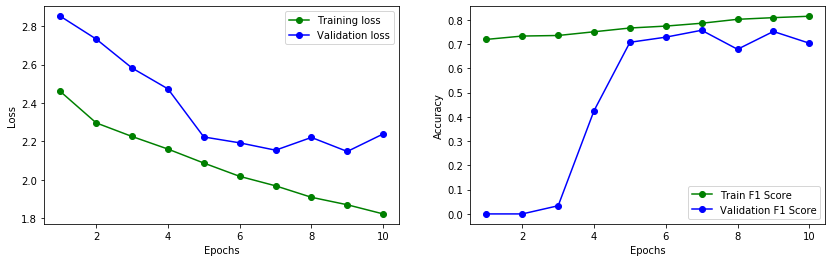

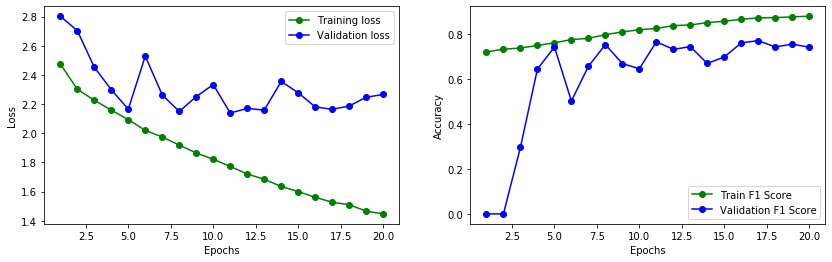

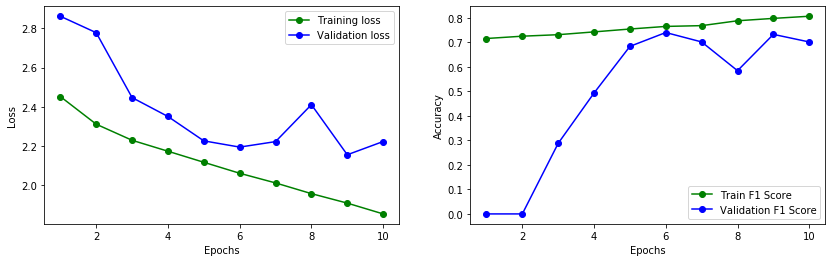

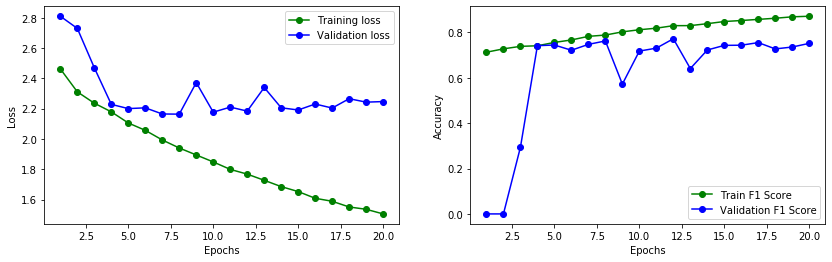

In [156]:
a=range(len(headlineshape_parameter_list))
b=range(len(bodyshape_parameter_list))
c=range(len(optimizer_parameter_list))
d=range(len(epochs_parameter_list))
m=0 #this is for printing out the graph at the end

#create list to save the model score
accuracylist = []
historylist = []
timelist = []
for i, j, k,l in [(i,j,k,l) for i in a for j in b for k in c for l in d]: 
    start_time_baseline = timeit.default_timer()
    headlineshape_parameter = headlineshape_parameter_list[i]
    bodyshape_parameter = bodyshape_parameter_list[j]
    max_length = headlineshape_parameter+bodyshape_parameter
    optimizer_parameter = optimizer_parameter_list[k]
    epochs_parameter = epochs_parameter_list[l]
    print('Headline Shape: '+str(headlineshape_parameter))
    print('Body Shape: '+ str(bodyshape_parameter))
    print('Max length: '+ str(max_length))
    print('Optimizer: '+ str(optimizer_parameter))
    print('Epochs: '+ str(epochs_parameter))

    ###Tokenizer + Pad
    all_data_emb = all_data_processed.copy()
    #train_data
    all_data_token = combined_df_t['Headline']+combined_df_t['articleBody']

    # prepare tokenizer
    t = Tokenizer()
    t.fit_on_texts(all_data_token)
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_docs = t.texts_to_sequences(test_data)

    embeddings_index_ex = dict()
    with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index_ex[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index_ex))

    # create a weight matrix for words in training docs
    embedding_matrix_ex = np.zeros((vocab_size, 50))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index_ex.get(word)
        if embedding_vector is not None:
            embedding_matrix_ex[i] = embedding_vector

    padded_docs_h = encodeDoc(dev_data['Headline'],headlineshape_parameter)
    padded_docs_b = encodeDoc(dev_data['articleBody'], bodyshape_parameter)
    padded_test_docs_h = encodeDoc(test_data['Headline'],headlineshape_parameter)
    padded_test_docs_b = encodeDoc(test_data['articleBody'], bodyshape_parameter)

    ## Embedding

    # Note that we can name any layer by passing it a "name" argument.
    headline_input = Input(shape=(headlineshape_parameter,), dtype='int32', name='headline_input')
    # This embedding layer will encode the input sequence
    # into a sequence of dense 512-dimensional vectors.
    emb_h = Embedding(vocab_size, 50, weights=[embedding_matrix_ex], input_length=headlineshape_parameter, trainable=False)(headline_input)
    # Note that we can name any layer by passing it a "name" argument.
    body_input = Input(shape=(bodyshape_parameter,), dtype='int32', name='body_input')
    # This embedding layer will encode the input sequence
    # into a sequence of dense 512-dimensional vectors.
    emb_b = Embedding(vocab_size, 50, weights=[embedding_matrix_ex], input_length=bodyshape_parameter, trainable=False)(body_input)

    ## Base Model - LSTM

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    lstm_out_h = Bidirectional(LSTM(32))(emb_h)
    headline_out = Dense(4, activation='softmax', name='headline_out')(lstm_out_h)
    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    lstm_out_b = Bidirectional(LSTM(32))(emb_b)
    body_out = Dense(4, activation='softmax', name='body_out')(lstm_out_b)

    #### Concatenate headline and body output from LSTM

    conc = tf.keras.layers.concatenate([headline_out, body_out])

    # We stack a deep densely-connected network on top
    x = Dense(768, activation='relu')(conc)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)
    x = tf.keras.layers.Reshape((64,12))(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', strides=1)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
    x = tf.keras.layers.Flatten()(x)

    #And finally we add the main logistic regression layer
    main_output = tf.keras.layers.Dense(4, activation='softmax', name='main_output')(x)

    model5 = Model(inputs=[headline_input, body_input], outputs=[main_output, headline_out, body_out ])
    model5.summary()

    model5.compile(optimizer=optimizer_parameter, loss='categorical_crossentropy',metrics=['accuracy', f1_metric])

    # fit the model
    history = model5.fit([padded_docs_h, padded_docs_b], [dev_labels_1h,dev_labels_1h,dev_labels_1h], batch_size=batch_size, epochs=epochs_parameter, validation_split= 0.2)

    # evaluate the model
    accuracy = model5.evaluate([padded_test_docs_h,padded_test_docs_b], [test_labels_1h,test_labels_1h,test_labels_1h], verbose=1)
    print('Combined Loss: %f' % (accuracy[1]))
    print('Accuracy: %f' % (accuracy[4]))
    print('F1 Score: %f' % (accuracy[5]))
    
    #Calculate run time
    elapsed_baseline = timeit.default_timer() - start_time_baseline
    timelist.append(elapsed_baseline)
    ### F1 Score, Loss, Accuracy

    print(len(accuracylist))
    print(accuracylist)
    print(len(historylist))
    print(historylist)

    accuracylist.append(accuracy)
    historylist.append(history)
    print(len(accuracylist))
    print(accuracylist)
    print(len(historylist))
    print(historylist)


    print(m)
    showResults(historylist[m])
    m += 1 

### End of For Loop

### Baseline: Select best baseline model

In [158]:
type(accuracylist)
best_baseline = [el[5] for el in accuracylist]

type(b)
best_baseline_F1_idx=np.argsort(best_baseline)[-5:]
best_baseline = np.array(best_baseline)
best_baseline[best_baseline.argsort()[-5:]]
print('Total combination: ',str(len(best_baseline)))
print('F1 Score:' )
print(best_baseline[best_baseline.argsort()[-3:]])
print(best_baseline_F1_idx)
print('Accuracy:')
best_baseline2 = [el[4] for el in accuracylist]
np.argsort(best_baseline2)[-3:]
best_baseline2 = np.array(best_baseline2)
best_baseline2[best_baseline2.argsort()[-3:]]
print(best_baseline2[best_baseline2.argsort()[-3:]])
print(best_baseline2.argsort()[-5:])

Total combination:  4
F1 Score:
[0.6964431 0.7369572 0.7444878]
[0 2 1 3]
Accuracy:
[0.717 0.746 0.755]
[2 0 1 3]


m= 0
0 0 0 0
index: 0 model detail: 
headline len: 15
body len: 100
optimizer: <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000023B5F73A308>
epochs: 10
time: 7 mins
Best validation F1 Score: 0.7568
Best train F1 Score: 0.8146
----------------------------
m= 1
0 0 0 1
index: 1 model detail: 
headline len: 15
body len: 100
optimizer: <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000023B5F73A308>
epochs: 20
time: 15 mins
Best validation F1 Score: 0.7715
Best train F1 Score: 0.8801
----------------------------
m= 2
0 1 0 0
index: 2 model detail: 
headline len: 15
body len: 185
optimizer: <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000023B5F73A308>
epochs: 10
time: 13 mins
Best validation F1 Score: 0.7395
Best train F1 Score: 0.8059
----------------------------
m= 3
0 1 0 1
index: 3 model detail: 
headline len: 15
body len: 185
optimizer: <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000023B5F73A3

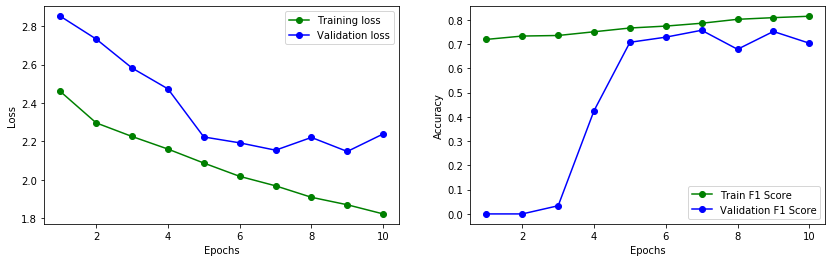

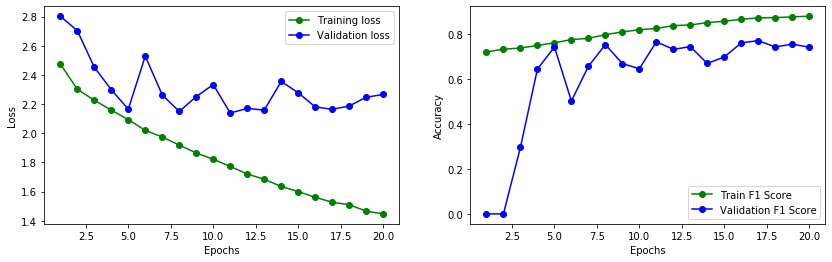

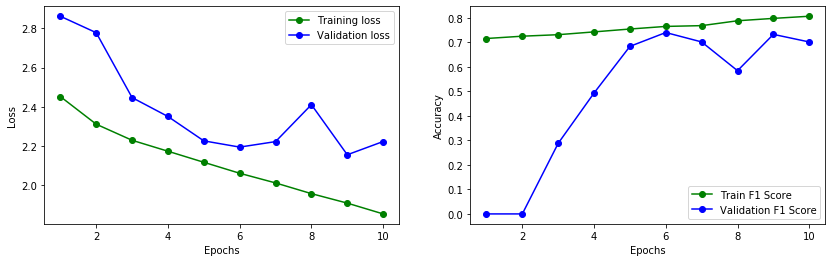

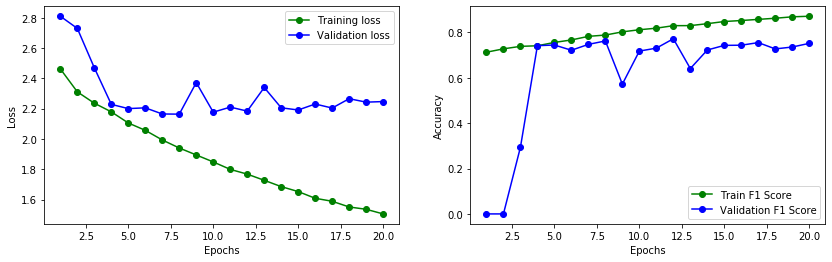

In [159]:
m=0 #this is for printing out the graph at the end
indexnum = 106
for i, j, k,l in [(i,j,k,l) for i in a for j in b for k in c for l in d]:
    if m in best_baseline_F1_idx:
        print("m=",str(m))
        print(i, j, k,l)
        print('index: '+str(m)+' model detail: ')
        print('headline len: '+str(headlineshape_parameter_list[i]))
        print('body len: '+str(bodyshape_parameter_list[j]))
        print('optimizer: '+str(optimizer_parameter_list[k]))
        print('epochs: '+str(epochs_parameter_list[l]))
        print('time: '+str(int(timelist[m]/60))+' mins')
        
        showResults(historylist[m])
        print('----------------------------')
    m+=1

### Best Baseline model based on validation F1 Score (Body text shorten: keep first n tokens)

index: 3, model detail: 
headline len: 15
body len: 185
optimizer: <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x0000023B5F73A308>
epochs: 20
Best validation F1 Score: 0.7721
Best train F1 Score: 0.8713


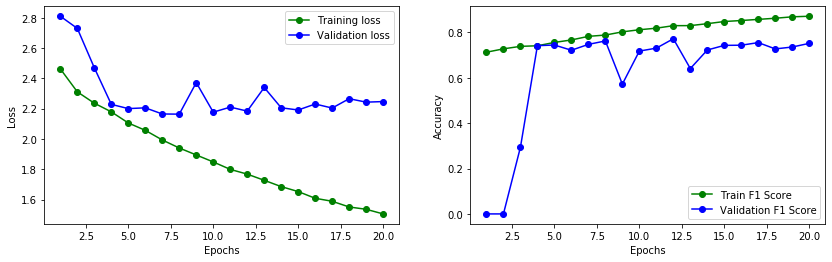

In [160]:
print('index: 3, model detail: ')
print('headline len: '+str(headlineshape_parameter_list[0]))
print('body len: '+str(bodyshape_parameter_list[1]))
print('optimizer: '+str(optimizer_parameter_list[0]))
print('epochs: '+str(epochs_parameter_list[1]))
showResults(historylist[3])

## 2. BERT Base Model (Body text shorten: keep first n tokens)

### BERT 1. Tokenizer

1) Tokenize the sentences.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. 

In [162]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()


def addWord(word):    
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


def token_trim(maxlengthT,textseriesT,maxlengthB,textseriesB):
    # 1. tokenize title
    # lists for sentences, tokens, labels, etc.  
    sentenceList = []
    sentenceTokenList = []
    sentLengthList = []

    # lists for BERT input
    bertSentenceIDs = []
    bertMasks = []
    bertSequenceIDs = []

    sentence = ''

    # always start with [CLS] tokens
    sentenceTokens = ['[CLS]']
    for line in textseriesT:
    
        cleanLine = re.sub(r'[^a-zA-Z0-9\s]+', '', line)  # remove special characters 

        sent = cleanLine.split(',')    
        sentenceLength = min(maxlengthT -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)


        # Create space for at least a final '[SEP]' token
        if sentenceLength >= maxlengthT - 1: 
            sentenceTokens = sentenceTokens[:maxlengthT - 1]

            # add a ['SEP'] token and padding

        sentenceTokens += ['[PAD]'] * (maxlengthT -1 - len(sentenceTokens))

        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (maxlengthT -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (maxlengthT))

        sentence = ''
        sentenceTokens = ['[CLS]']

        sentence += ' ' + sent[0]

        for word in sent:
            addDict = addWord(word)
            sentenceTokens += addDict['wordToken']
            

    sentLengthListT = sentLengthList[2:]
    sentenceTokenListT = sentenceTokenList[2:]
    bertSentenceIDsT = bertSentenceIDs[2:]
    bertMasksT = bertMasks[2:]
    bertSequenceIDsT = bertSequenceIDs[2:]
    #-----------------------------------------------------------------------
    #tokenize body
    #trim body size to speed this up
    ##assume average word length is 7, on the higher side. so there's always more than enough letters
    bodytrimlen = maxlengthB*7
    trimedbody=textseriesB.str.slice(0,bodytrimlen)
    # lists for sentences, tokens, labels, etc.  
    sentenceList = []
    sentenceTokenList = []
    sentLengthList = []

    # lists for BERT input
    bertSentenceIDs = []
    bertMasks = []
    bertSequenceIDs = []

    sentence = ''

    # always start with [SEP] tokens
    sentenceTokens = ['[SEP]']
    for line in textseriesB:

        cleanLine = re.sub(r'[^a-zA-Z0-9\s]+', '', line)  # remove special characters

        sent = cleanLine.split(',')         

        sentenceLength = min(maxlengthB -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)


        # Create space for at least a final '[SEP]' token
        if sentenceLength >= maxlengthB - 1: 
            sentenceTokens = sentenceTokens[:maxlengthB - 2]

            # add a ['SEP'] token and padding

        sentenceTokens += ['[PAD]'] * (maxlengthB -2 - len(sentenceTokens))
        sentenceTokens += ['[SEP]']

        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (maxlengthB -1 - sentenceLength ))
        bertSequenceIDs.append([1] * (maxlengthB))

        sentence = ''
        sentenceTokens = ['[SEP]']

        sentence += ' ' + sent[0]

        for word in sent:
            addDict = addWord(word)
            sentenceTokens += addDict['wordToken']
        
    sentLengthListB = sentLengthList[2:]
    sentenceTokenListB = sentenceTokenList[2:]
    bertSentenceIDsB = bertSentenceIDs[2:]
    bertMasksB = bertMasks[2:]
    bertSequenceIDsB = bertSequenceIDs[2:]
    #combine title and body
    return sentLengthListT, sentLengthListB, sentenceTokenListT, sentenceTokenListB, bertSentenceIDsT, bertSentenceIDsB, bertMasksT, bertMasksB, bertSequenceIDsT, bertSequenceIDsB
    

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [163]:
# Extract column for just labels
labels_t = combined_df_t['Stance']

combined_df_t = combined_df_t.rename(columns={'summary_random': 'articleBody'})
combined_df_t.rename(columns={'summary_random': 'articleBody'}, inplace=True)

# Drop columns that are strings
all_data_processed = combined_df_t.drop(['Stance'], axis=1)

new_labels1= labels_t.copy()
new_labels1[new_labels1=='agree']=3
new_labels1[new_labels1=='unrelated']=2
new_labels1[new_labels1=='disagree']=0
new_labels1[new_labels1=='discuss']=1
new_labels1h = np_utils.to_categorical(new_labels1)

all_data_processed.head()

# Set some variables to hold test, dev, and training data.
test_data, test_labels_1h = all_data_processed[:1000], new_labels1h[:1000]
dev_data, dev_labels_1h = all_data_processed[1001:7000], new_labels1h[1001:7000]
train_data, train_labels_1h = all_data_processed[7001:], new_labels1h[7001:]

In [164]:
test_tina = all_data_processed

headline_t = test_tina['Headline']

body_t = test_tina['articleBody']

In [165]:
short_head = headline_t[:7000]
short_body = body_t[:7000]

### BERT Set Parameters

In [166]:
#Parameters
# Define maximal length of input 'sentences' (post tokenization).
headlineshape_parameter_list = [15]
bodyshape_parameter_list = [100]

#create optimizer options
sgd1 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd2 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
Adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.01)
Adadelta = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
adam1 = 'adam'
optimizer_parameter_list = [Adadelta]

#epochs, batch parameter
epochs_parameter_list = [10]
batch_size = 30

In [167]:
#edit length for tokenizer
start_time3 = timeit.default_timer()
title_token_length = 15
body_token_length = 100
max_length = title_token_length+body_token_length
A1, A2, B1, B2, C1, C2, D1, D2, E1, E2  = token_trim(title_token_length,short_head,body_token_length,short_body)
elapsed3 = timeit.default_timer() - start_time3
print(elapsed3)

46.175081299999874


In [168]:
sentLengthList = [m+n for m,n in zip(A1,A2)]
sentenceTokenList= [m+n for m,n in zip(B1,B2)]
bertSentenceIDs= [m+n for m,n in zip(C1,C2)]
bertMasks = [m+n for m,n in zip(D1,D2)]
bertSequenceIDs = [m+n for m,n in zip(E1,E2)]

In [169]:
bertSentenceIDs= [m+n for m,n in zip(C1,C2)]
for i in range(len( bertSentenceIDs)):
    bertSentenceIDs[i].append(0)
    bertSentenceIDs[i].append(0)

Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

In [170]:
bodyfulllen = []
for line in range(len(body_t)):
    trimedbody=body_t[line]
    str1 = trimedbody
    t = 1
    for i in range(len(str1)):
        if(str1[i] == ' ' or str1 == '\n' or str1 == '\t'):
            t = t + 1

    bodyfulllen.append(t)


#headline_t = test_tina['Headline']

#body_t = test_tina['articleBody']

In [171]:
titlefulllen = []
for line in range(len(headline_t)):
    trimed=headline_t[line]
    str1 = trimed
    t = 1
    for i in range(len(str1)):
        if(str1[i] == ' ' or str1 == '\n' or str1 == '\t'):
            t = t + 1

    titlefulllen.append(t)

Text(0.5, 1.0, 'Histogram of all title length')

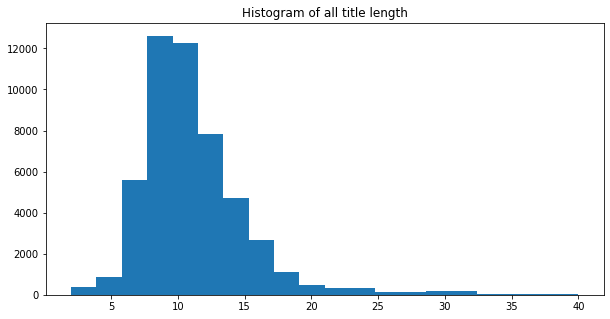

In [172]:
plt.figure(figsize=(10,5))
plt.hist(np.array(titlefulllen), bins=(20))
plt.title("Histogram of all title length",loc='center')

Text(0.5, 1.0, 'Histogram of all body length')

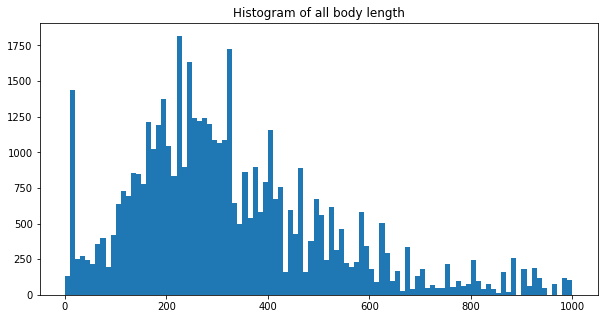

In [173]:

plt.figure(figsize=(10,5))
plt.hist(np.array(bodyfulllen),range=[0, 1000], bins=(100))
plt.title("Histogram of all body length",loc='center')

(array([1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 4.00e+00,
        5.00e+00, 0.00e+00, 5.00e+00, 8.00e+00, 1.10e+01, 2.20e+01,
        2.10e+01, 1.60e+01, 1.30e+01, 0.00e+00, 1.00e+01, 2.00e+01,
        1.80e+01, 8.00e+00, 1.10e+01, 1.40e+01, 0.00e+00, 1.30e+01,
        1.20e+01, 5.00e+00, 5.00e+00, 5.00e+00, 2.00e+00, 4.00e+00,
        0.00e+00, 4.00e+00, 0.00e+00, 1.00e+00, 2.00e+00, 1.00e+00,
        2.00e+00, 0.00e+00, 4.00e+00, 7.00e+00, 2.00e+00, 1.00e+00,
        5.00e+00, 4.00e+00, 1.10e+01, 0.00e+00, 1.00e+00, 2.00e+00,
        3.00e+00, 2.00e+00, 2.00e+00, 1.00e+00, 0.00e+00, 2.00e+00,
        5.00e+00, 0.00e+00, 1.00e+01, 8.00e+00, 1.00e+00, 2.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00, 5.00e+00, 3.00e+00, 7.00e+00, 3.00e+00,
        3.00e+00, 8.00e+00, 2.00e+00, 0.00e+00, 8.00e+00, 0.00e+00,
        5.00e+00, 2.00e+00, 3.00e+00, 3.00e+00, 0.00e+00, 4.00e+00,
        1.00e+01, 1.40e+01, 0.00e+00, 1.10e+01, 

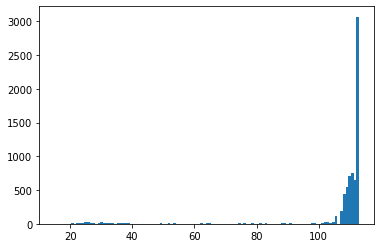

In [174]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

An average sentence length of ~25 (incl. extra tokens!) is roughly expected. It turns out that on these types of corpora an average sentence length of ~20 tends to be seen. The big spike on the right obviously corresponds to all sentences that we had to truncate. 

Next, we analyze the distribution of ner labels. First, we assign numbers to the labels and look at the overall distribution:

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [175]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [176]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [177]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []
trainLabel_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []
testLabels_ids = []

valSentence_id = []
valMasks = []
valSequence_ids = []
valLabels_ids = []

testSentence_ids= bert_inputs[0][:1000]
testMasks = bert_inputs[1][:1000]
testSequence_ids= bert_inputs[2][:1000]
testLabels_ids = new_labels1h[1:1001]    

valSentence_ids= bert_inputs[0][1000:2200]
valMasks = bert_inputs[1][1000:2200]
valSequence_ids= bert_inputs[2][1000:2200]
valLabels_ids = new_labels1h[1001:2201] 

trainSentence_ids = bert_inputs[0][2200:7000]
trainMasks = bert_inputs[1][2200:7000]
trainSequence_ids = bert_inputs[2][2200:7000]
trainLabel_ids = new_labels1h[2201:7001]        

        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])
X_val = np.array([valSentence_ids,valMasks,valSequence_ids])

trainLabel_ids = np.array(trainLabel_ids)
testLabels_ids = np.array(testLabels_ids)
valLabels_ids = np.array(valLabels_ids)

In [178]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
    k_end_val = X_val[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    
print(k_end_train)
print(k_end_test)
print(k_end_val)
print(len(X_train[0]))
print(len(X_test[2]))
print(len(X_val[0]))

bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]
bert_inputs_val_k = [X_val[0][k_start:k_end_val], X_val[1][k_start:k_end_val], 
                      X_val[2][k_start:k_end_val]]

labels_train_k = trainLabel_ids[k_start:k_end_train]
labels_test_k = testLabels_ids[k_start:k_end_test]
labels_val_k = valLabels_ids[k_start:k_end_val]

4798
1000
1200
4798
1000
1200


### IV.2 Keras BERT Layer<a id="bert_layer"/>


We start by creating a Keras layer for the BERT module from Tensorflow hub. (Note: This code is simply a more specified and for our purposes adjusted version of the equivalent cell in (https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b)   

Note, how then trainable variables are built. (See also: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

In [179]:
class BertLayer(tf.keras.layers.Layer):

    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):

        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url        

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        trainable_vars = self.bert.variables     

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)   

        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):

        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )

        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]

        return result


    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### IV.3 Model Construction<a id="ner_model"/>

In [180]:
def stance_model(max_input_length, train_layers, optimizer):
    """
    Implementation of Sentence Class model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_input_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_input_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_input_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(bert_inputs)
    
    print(bert_sequence)   

    x = tf.keras.layers.Dropout(0.25)(bert_sequence)
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)
    x = tf.keras.layers.Reshape((64,12))(x)
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', strides=1)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
    x = tf.keras.layers.Flatten()(x)
       
    # And finally we add the main logistic regression layer
    pred = tf.keras.layers.Dense(4, activation='softmax', name='stance')(x)
        
    print('pred: ', pred)  
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_metric])
    
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [181]:
def stance_model_n(max_input_length, train_layers, optimizer):
    """
    Implementation of Sentence Class model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_input_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_input_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_input_length,), name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(bert_inputs)
    
    print(bert_sequence)   

    x = tf.keras.layers.Dropout(0.25)(bert_sequence)
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(x)

    # And finally we add the main logistic regression layer
    pred = tf.keras.layers.Dense(4, activation='softmax', name='stance')(x)
        
    print('pred: ', pred)  
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_metric])
    
    
    model.summary()
    
    return model


## V. Model Runs/Experiments<a id="runs"/>

### V.1. With BERT-Layer Re-Training<a id="retrain"/>

It is time to run the first test.

In [182]:
# This is a hepler method to display and plot results
def showResultsBERT(history):
    val_acc = np.array(history.history['val_f1_metric'])
    train_ac = np.array(history.history['f1_metric'])
    print("Best validation F1 Score: %.4f" % max(val_acc))
    print("Best train F1 Score: %.4f" %  max(train_ac))

    plt.figure(figsize=(14, 4))
    ax = plt.subplot(121)

    # Plot Loss Vs Epoch for Train and validation Sets
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot( [i + 1 for i in range(len(history.history['loss']))], history.history['loss'],  '-gD', marker='o', label="Training loss")
    plt.plot( [i + 1 for i in range(len(history.history['val_loss']))], history.history['val_loss'],  '-bD', marker='o', label="Validation loss")
    plt.legend(loc="best")

    # Plot Accuracy Vs Epoch for Train and validation Sets
    ax = plt.subplot(122)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot( [i + 1 for i in range(len(history.history['f1_metric']))], history.history['f1_metric'],  '-gD', marker='o', label="Train F1 Score")
    plt.plot( [i + 1 for i in range(len(history.history['val_f1_metric']))], history.history['val_f1_metric'],  '-bD', marker='o', label="Validation F1 Score")
    plt.legend(loc="best")

In [183]:
bert_inputs_train_k[0].shape

(4798, 115)

# 15 tokens for title and 100 tokens for body Model

In [184]:
#Start session
sess = tf.Session()
model2length = title_token_length+body_token_length
model2 = stance_model(model2length, train_layers=10, optimizer = "adam")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("bert_layer_3/bert_layer_3_module_apply_tokens/bert/pooler/dense/Tanh:0", shape=(?, 768), dtype=float32)
pred:  Tensor("stance_3/Softmax:0", shape=(?, 4), dtype=float32)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 115)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 115)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 115)]        0                                            
__________________________________________________________________________________________________
bert_layer_3 (

In [185]:
# different length for title and body
# Instantiate variables
initialize_vars(sess)
start_time4 = timeit.default_timer()

history2 = model2.fit(
    bert_inputs_train_k, 
    {"stance": labels_train_k },
    validation_data=(bert_inputs_val_k, {"stance": labels_val_k }),
    epochs=15,
    batch_size=30
)

elapsed4 = timeit.default_timer() - start_time4
print(elapsed4)

Train on 4798 samples, validate on 1200 samples
Epoch 1/15
4798/4798 [==============================] - 54s 11ms/sample - loss: 0.3538 - acc: 0.8745 - f1_metric: 0.8685 - val_loss: 0.2670 - val_acc: 0.8967 - val_f1_metric: 0.8998
Epoch 2/15
4798/4798 [==============================] - 50s 10ms/sample - loss: 0.2883 - acc: 0.8939 - f1_metric: 0.8958 - val_loss: 0.4127 - val_acc: 0.8467 - val_f1_metric: 0.8473
Epoch 3/15
4798/4798 [==============================] - 52s 11ms/sample - loss: 0.2412 - acc: 0.9135 - f1_metric: 0.9137 - val_loss: 0.2818 - val_acc: 0.9108 - val_f1_metric: 0.9118
Epoch 4/15
4798/4798 [==============================] - 52s 11ms/sample - loss: 0.2266 - acc: 0.9223 - f1_metric: 0.9229 - val_loss: 0.2381 - val_acc: 0.9150 - val_f1_metric: 0.9207
Epoch 5/15
4798/4798 [==============================] - 54s 11ms/sample - loss: 0.1982 - acc: 0.9310 - f1_metric: 0.9297 - val_loss: 0.4074 - val_acc: 0.8908 - val_f1_metric: 0.8907
Epoch 6/15
4798/4798 [====================

In [186]:
# evaluate the model
accuracy = model2.evaluate(bert_inputs_test_k, {"stance": labels_test_k }, verbose=1)
print('Combined Loss: %f' % (accuracy[0]))
print('Accuracy: %f' % (accuracy[1]))
print('F1 Score: %f' % (accuracy[2]))

1000/1000 [==============================] - 7s 7ms/sample - loss: 0.4515 - acc: 0.9080 - f1_metric: 0.9018
Combined Loss: 0.451487
Accuracy: 0.908000
F1 Score: 0.901801


Best validation F1 Score: 0.9254
Best train F1 Score: 0.9800


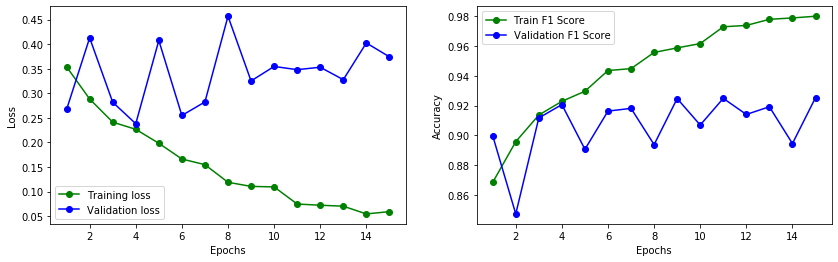

In [187]:
showResultsBERT(history2)